In [1]:
import datetime
import snscrape.modules.twitter as sntwitter
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import tqdm.notebook as tqdm

In [2]:
import sys
import re
import string
import json
import os

In [103]:
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()

from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgb

from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ritod\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ritod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ritod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#Get stock data for the given Stock Name
def getStockDetails(stockname,start_time,end_time):
  company = yf.Ticker(stockname)
  company.info.get("longName")
  stockData = yf.download(stockname, start=start_time, end=end_time)
  print("\n Stock Data Obtained ")
  print(stockData.head())
  print("\n")
  plt.title('Time series chart of Closing stocks for ' + company.info.get("longName"))
  plt.plot(stockData["Close"])
  plt.show()
  print("\n")
  stockData.to_csv('stockData_' + stockname + '.csv')

[*********************100%***********************]  1 of 1 completed

 Stock Data Obtained 
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-03-16  157.050003  160.000000  154.460007  159.589996  159.134827   
2022-03-17  158.610001  161.000000  157.630005  160.619995  160.161880   
2022-03-18  160.509995  164.479996  159.759995  163.979996  163.512299   
2022-03-21  163.509995  166.350006  163.009995  165.380005  164.908310   
2022-03-22  165.509995  169.419998  164.910004  168.820007  168.338501   

               Volume  
Date                   
2022-03-16  102300200  
2022-03-17   75615400  
2022-03-18  123511700  
2022-03-21   95811400  
2022-03-22   81532000  




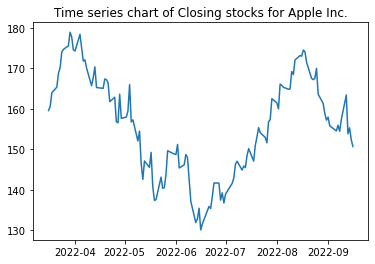

In [5]:
getStockDetails('AAPL', '2022-03-17', '2022-09-17')

In [6]:
#Method for data cleaning
class TweetCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation) # to remove punctuation from each word in tokenize

    def compound_word_split(self, compound_word):
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', compound_word)
        return [m.group(0) for m in matches]

    def remove_non_ascii_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])

    def get_cleaned_text(self, text):
        cleaned_tweet = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_tweet =  self.remove_non_ascii_chars(cleaned_tweet)
        if re.match(r'RT @[_A-Za-z0-9]+:',cleaned_tweet):
            cleaned_tweet = cleaned_tweet[cleaned_tweet.index(':')+2:]
        cleaned_tweet = self.remove_hyperlinks(cleaned_tweet)
        cleaned_tweet = cleaned_tweet.replace('#','HASHTAGSYMBOL').replace('@','ATSYMBOL') # to avoid being removed while removing punctuations
        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_tweet)] # remove punctuations and tokenize
        tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1] # remove stopwords and single length words
        cleaned_tweet = ' '.join(tokens)
        cleaned_tweet = cleaned_tweet.replace('HASHTAGSYMBOL','#').replace('ATSYMBOL','@')
        cleaned_tweet = cleaned_tweet
        return cleaned_tweet

    def clean_tweets(self, tweets, is_bytes = False):   
        test_tweet_list = []
        for tweet in tweets:
            if is_bytes:
                test_tweet_list.append(self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8")))
            else:
                test_tweet_list.append(self.get_cleaned_text(tweet))
        return test_tweet_list
    
    def clean_single_tweet(self, tweet, is_bytes = False):  
        if is_bytes:
             return self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8"))
        return self.get_cleaned_text(tweet)
    
    def cleaned_file_creator(self, op_file_name, value1, value2):
        csvFile = open(op_file_name, 'w+')
        csvWriter = csv.writer(csvFile)
        for tweet in range(len(value1)):
            csvWriter.writerow([value1[tweet], value2[tweet]])
        csvFile.close()

In [8]:
# Method to get tweets for the given stock name based on retweet count
def fetchTweets(stockname, start_time, end_time):
    csvFile = open('tweets_' + stockname + '.csv', 'a',encoding="utf-8")
    csvWriter = csv.writer(csvFile, lineterminator= '\n')
    tweet_list = []
    cleaner = TweetCleaner()
    date_range = pd.date_range(start=start_time, end=end_time, freq='D')
    for date in tqdm.tqdm(date_range):
        start = str(date).split(' ')[0]
        end = str(date + pd.Timedelta(days=1)).split(' ')[0]
        # print(start, end)
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(stockname + ' since:' + start + ' until:' + end + ' lang:en').get_items()):
            if i>100:
                break
            # print(tweet.content)
            tweet_text = cleaner.clean_single_tweet(tweet.content)
            tweetDate = tweet.date.strftime("%Y-%m-%d")
            tweet_list.append([tweet_text, tweet.retweetCount, tweetDate])
    # print(tweet_list)
    tweet_list.sort(key=lambda x: x[1], reverse=True)
    for tweet in tweet_list:
        # print(tweet)
        csvWriter.writerow([tweet[0], tweet[2]])
        

    # tweets = sntwitter.TwitterSearchScraper(stockname + ' since:' + start_time + ' until:' + end_time).get_items()
    # for i,tweet in tqdm.tqdm_notebook(enumerate(tweets), total = 1000):
    #     if i > 1000:
    #         break
    #     print(tweet.content)
    #     tweet_text = cleaner.get_cleaned_text(tweet.content.encode('utf-8').decode())
    #     tweetDate = tweet.date.strftime("%Y-%m-%d")
    #     tweet_retweet_count = tweet.retweetCount
    #     tweet_list.append([tweet_text, tweet_retweet_count, tweetDate])
    # tweet_list.sort(key=lambda x: x[1], reverse=True)
    # for tweet in tweet_list:
    #     csvWriter.writerow([tweet[0],  tweet[2]])

In [9]:
fetchTweets('AAPL', '2022-03-17', '2022-09-17')

  0%|          | 0/185 [00:00<?, ?it/s]

In [66]:
#Method for sentiment analysis for tweets
def sentimentAnalysis(stockname):
  data = pd.read_csv('tweets_' + stockname  + '.csv', encoding='utf-8',names=['Tweets','Dates'])
  df = pd.DataFrame(columns=['Tweets','Dates','Sentiment'])
  # print(data.head())
  # data.to_csv('sentimentAnalysis_' + stockname  + '.csv')
  # Find sentiment of each tweet using VADER
  for i in range(len(data)):
    sentence_i = unicodedata.normalize('NFKD', str(data['Tweets'][i]))
    sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
    df.loc[i] = [data['Tweets'][i], data['Dates'][i], sentence_sentiment['compound']]

  df.to_csv('sentimentAnalysis_' + stockname  + '.csv')        

  # posi=0
  # nega=0
  # neutral = 0
  # for i in range (0,len(data)):
  #   get_val = data.Comp[i]
  #   if(float(get_val)<(0)):
  #       nega=nega+1
  #   if(float(get_val>(0))):
  #       posi=posi+1
  #   if(float(get_val)==(0)):
  #       neutral=neutral+1
  
  # posper=(posi/(len(data)))*100
  # negper=(nega/(len(data)))*100
  # neutralper=(neutral/(len(data)))*100

  # arr=np.asarray([posper,negper,neutralper], dtype=int)
  # plt.figure()
  # plt.pie(arr,labels=['positive','negative', 'neutral'])
  # plt.plot()

  # print("% of positive tweets= ",posper)
  # print("% of negative tweets= ",negper)
  # print("% of neutral tweets= ",neutralper)

In [67]:
sentimentAnalysis('AAPL')

In [76]:
def merge(stockname):
    df1 = pd.read_csv('sentimentAnalysis_' + stockname  + '.csv')
    df2 = pd.read_csv('stockData_' + stockname  + '.csv')
    df3 = pd.DataFrame(columns=['Tweets','Dates','Sentiment','Open','High','Low','Close','Adj Close','Volume'])
    for i in range(len(df1)):
        for j in range(len(df2)):
            if df1['Dates'][i] == df2['Date'][j]:
                df3.loc[i] = [df1['Tweets'][i], df1['Dates'][i], df1['Sentiment'][i], df2['Open'][j], df2['High'][j], df2['Low'][j], df2['Close'][j], df2['Adj Close'][j], df2['Volume'][j]]
    df3.to_csv('merged_' + stockname  + '.csv')

In [77]:
merge('AAPL')

In [81]:
def plot_sentiment(stockname):
    df = pd.read_csv('merged_' + stockname  + '.csv')
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.set_index('Dates')
    df['Sentiment'].plot(figsize=(16, 6))
    plt.title('Sentiment Analysis of ' + stockname)
    plt.ylabel('Sentiment')
    plt.show()

def plot_price(stockname):
    df = pd.read_csv('merged_' + stockname  + '.csv')
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.set_index('Dates')
    df['Close'].plot(figsize=(16, 6))
    plt.title('Price of ' + stockname)
    plt.ylabel('Price')
    plt.show()

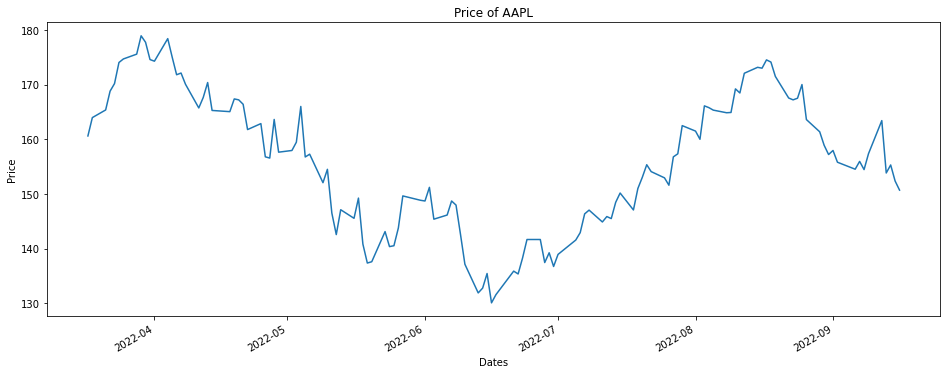

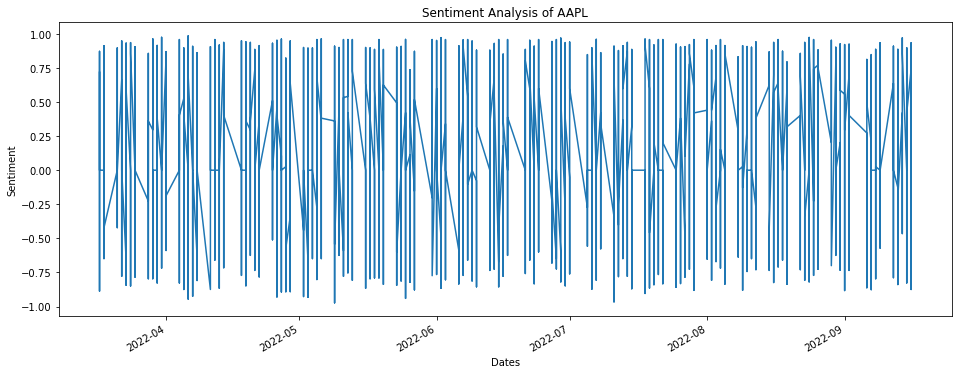

In [82]:
plot_price('AAPL')
plot_sentiment('AAPL')

In [89]:
def sentiment_closing(stockname):
    df = pd.read_csv('merged_' + stockname  + '.csv')
    price = df['Close']
    sentiment = df['Sentiment']
    data = pd.DataFrame({'Price': price, 'Sentiment': sentiment})
    data.plot.scatter(x='Sentiment', y='Price', figsize=(16, 6))
    data.to_csv('sentiment_closing_' + stockname  + '.csv')

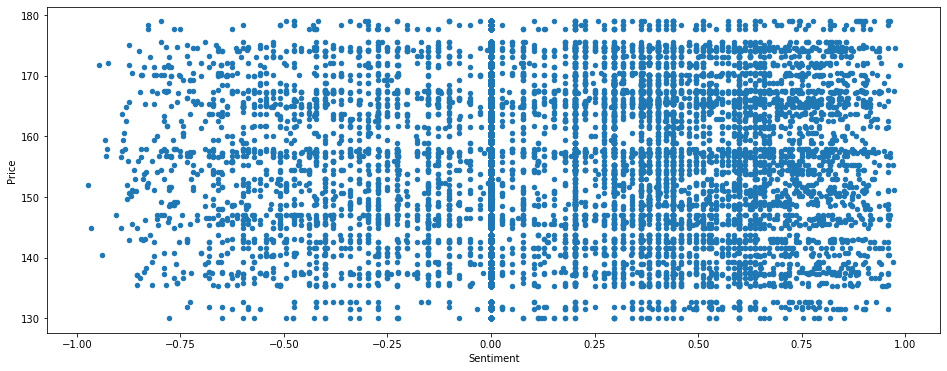

In [90]:
sentiment_closing('AAPL')

In [115]:
def Model(stockname):
    df = pd.read_csv('sentiment_closing_' + stockname  + '.csv')
    X = df['Sentiment'].values.reshape(-1, 1)
    y = df['Price'].values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf.fit(X_train, y_train.ravel())
    y_pred = svr_rbf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("SVR : ",rmse)

    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(X_train, y_train.ravel())
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Random Forest : ",rmse)
    
    xgbr = xgb(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
    xgbr.fit(X_train, y_train.ravel())
    y_pred = xgbr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("XGBoost : ",rmse)

    pickle.dump(xgbr,open('Bestmodel_' + stockname + '.sav', 'wb'))



In [116]:
Model('AAPL')

SVR :  12.291632700162786
Random Forest :  12.447501191161262
XGBoost :  12.242080145607623


In [147]:
from pandas import date_range

def plot(stockname, start_date, end_date):
    # Plot predicted values and date
    df = pd.read_csv('merged_' + stockname  + '.csv')
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.set_index('Dates')
    df['predicted'] = ""
    xgbr = pickle.load(open('Bestmodel_' + stockname + '.sav', 'rb'))
    for i in range(len(df)):
        df['predicted'][i] = xgbr.predict([[df['Sentiment'][i]]])
    df['predicted'] = df['predicted'].astype(float)
    # Remove duplicate dates
    df = df[~df.index.duplicated(keep='last')]
    # Plot between start_date and end_date
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    mask = (df.index > start_date) & (df.index <= end_date)
    df = df.loc[mask]
    df['predicted'].plot(figsize=(16, 6))
    plt.title('Predicted Price (Blue) vs Actual Price(Red) ' + stockname)
    plt.ylabel('Price')
    # Plot close price in the same graph
    df['Close'].plot(figsize=(16, 6))
    plt.xlabel('Date')
    plt.show()

pickle.dump(plot,open('plot.pkl', 'wb'))

C:\Users\ritod\AppData\Local\Temp\ipykernel_6172\114548273.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'][i] = xgbr.predict([[df['Sentiment'][i]]])


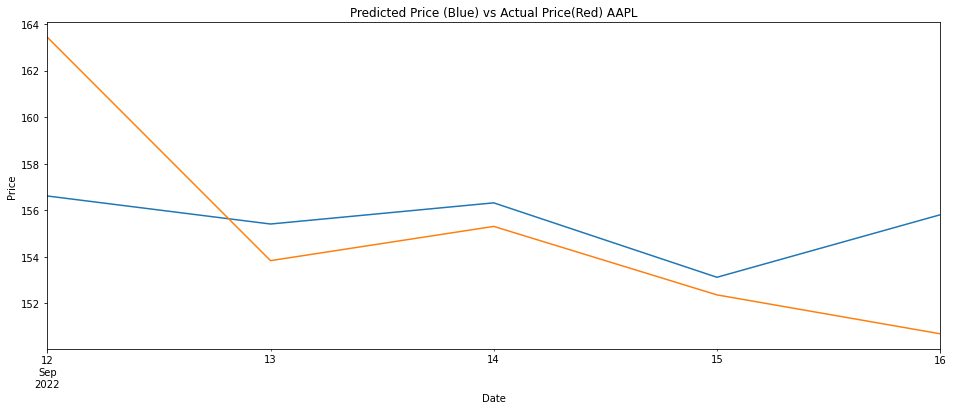

In [148]:
plot('AAPL', '2022-09-10', '2022-09-17')

In [13]:
def main():
  name = input("Enter a valid STOCKNAME of the Corporation: ") #enter the name of the company
  start_date = input("Enter the Start Date in the following format[YYYY-MM-DD]: ") #enter the start date to fetch the tweets
  end_date = input("Enter the End Date in the following format[YYYY-MM-DD]: " ) #enter the end date to fetch the tweets
  
  if(len(name) > 0):
    STOCKNAME  = name
  else:
    STOCKNAME = "AAPL"
  
  if(len(start_date) > 0):
    start_time = start_date
  else:
    start_time = "2018-01-01"
  
  if(len(end_date) > 0):
    end_time = end_date
  else:
    end_time = "2019-12-31"


  #Get Stock Details
  print("------------------------------ Getting Stock details -----------------------------")
  stockData = getStockDetails(STOCKNAME,start_time,end_time)
  print("Stock Details fetched! \n")

  #Fetching tweets
  print("------------------------------ Fetching Tweets -----------------------------")
  fetchTweets(STOCKNAME,start_time,end_time)
  print("Tweets fetched! \n")

  #Get tweets Per Day and get the stock closing values for each date
  print("------------------------------ Processing Tweets -----------------------------")
  processTweets(STOCKNAME)
  print("Processed Tweets ! \n")

------------------------------ Getting Stock details -----------------------------
[*********************100%***********************]  1 of 1 completed

 Stock Data Obtained 
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-02  86.129997  86.309998  85.500000  85.949997  81.168488  22483800
2018-01-03  86.059998  86.510002  85.970001  86.349998  81.546242  26061400
2018-01-04  86.589996  87.660004  86.570000  87.110001  82.263969  21912000
2018-01-05  87.660004  88.410004  87.430000  88.190002  83.283882  23407100
2018-01-08  88.199997  88.580002  87.599998  88.279999  83.368866  22113000




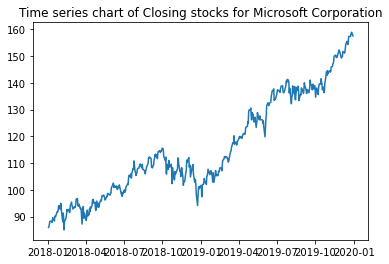



Stock Details fetched! 

------------------------------ Fetching Tweets -----------------------------


0it [00:00, ?it/s]

Error retrieving https://twitter.com/search?f=live&lang=en&q=MSFT+since%3A2018-01-01+until%3A2019-12-31&src=spelling_expansion_revert_click: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='twitter.com', port=443): Read timed out. (read timeout=10)"))
4 requests to https://twitter.com/search?f=live&lang=en&q=MSFT+since%3A2018-01-01+until%3A2019-12-31&src=spelling_expansion_revert_click failed, giving up.


ScraperException: 4 requests to https://twitter.com/search?f=live&lang=en&q=MSFT+since%3A2018-01-01+until%3A2019-12-31&src=spelling_expansion_revert_click failed, giving up.

In [14]:
main()